In [1]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from odps import ODPS
from odps import options
import oss2
from odps.df import DataFrame
import datetime
import pandas as pd
import numpy as np
import threading
import queue
import time

# connect信息
from ACCESS import ACCESS_ID
from ACCESS import SECRET_ACCESS_KEY
from ACCESS import ODPS_PROJECT
from ACCESS import ODPS_ENDPOINT

# # 此为外网地址
OSS_ENDPOINT = 'http://oss-cn-shanghai.aliyuncs.com'
OSS_BUCKET = 'hypertrons'

# oss实例
auth = oss2.Auth(ACCESS_ID, SECRET_ACCESS_KEY)
bucket = oss2.Bucket(auth, OSS_ENDPOINT, OSS_BUCKET)

# 创建odps实例
o = ODPS(ACCESS_ID, SECRET_ACCESS_KEY, project=ODPS_PROJECT, endpoint=ODPS_ENDPOINT)
options.tunnel.limit_instance_tunnel = False
# options.read_timeout = 3600000

hints = {'odps.sql.allow.fullscan': 'true', 'odps.sql.submit.mode': 'script'}
dim_github_repo = DataFrame(o.get_table('dim_github_repo'))
dim_github_repo.dtypes

odps.Schema {
  repo_id                                   int64           
  repo_name                                 string          
  org_id                                    int64           
  org_login                                 string          
  repo_description                          string          
  repo_size                                 int32           
  repo_stargazers_count                     int32           
  repo_forks_count                          int32           
  repo_language                             string          
  repo_has_issues                           int8            
  repo_has_projects                         int8            
  repo_has_downloads                        int8            
  repo_has_wiki                             int8            
  repo_has_pages                            int8            
  repo_license                              string          
  repo_default_branch                       string          
  repo_cre

In [27]:
drop_sql = '''
DROP TABLE IF EXISTS main_org;
CREATE TABLE IF NOT EXISTS main_org
(
    org_id STRING,
    org_login STRING
);
'''
o.execute_sql(drop_sql, hints=hints)

select_sql = '''
    set odps.sql.validate.orderby.limit=false;
    INSERT INTO main_org
    SELECT DISTINCT *
    FROM
        (SELECT repo_org_id, repo_org_login
            FROM Yue_ORG_To_ORG
            GROUP BY repo_org_id, repo_org_login
            ORDER BY count(actor_org_id) DESC
            LIMIT 15)
        UNION
        (SELECT actor_org_id, actor_org_login
            FROM Yue_ORG_To_ORG
            GROUP BY actor_org_id, actor_org_login
            HAVING actor_org_id!= '0'
            ORDER BY count(repo_org_id) DESC
            LIMIT 15)
'''
o.execute_sql(select_sql, hints=hints)

select_sql = '''
    SELECT DISTINCT org_id, org_login
    FROM main_org
'''
table = o.execute_sql(select_sql, hints=hints)
n = 0
with table.open_reader(tunnel=True) as reader:
    for record in reader:
        print(record.org_id, record.org_login)
        n += 1

107424 jenkinsci
131524 mozilla
1342004 google
13629408 kubernetes
1459110 IBM
1503512 Homebrew
22479449 MicrosoftDocs
22891503 Adalab
25064361 alchemycodelab
2810941 GoogleCloudPlatform
29209446 lappis-unb
36317571 Campus-Advisors
3637556 DefinitelyTyped
47359 apache
5429470 docker
5430905 rust-lang
6128107 vuejs
6154722 Microsoft
6154722 microsoft
66423638 IIM-Creative-Technology
6844498 Azure
69631 facebook
761456 hashicorp
9919 github
9950313 nodejs


In [28]:
# 数据清洗
drop_sql = '''
DROP TABLE IF EXISTS repo_info;
CREATE TABLE IF NOT EXISTS repo_info
(
    repo_id STRING,
    repo_name STRING,
    org_id STRING,
    org_login STRING,
    repo_language STRING,
    repo_description STRING,
    repo_stargazers_count STRING
);
'''
o.execute_sql(drop_sql, hints=hints)

select_sql = '''
    INSERT INTO repo_info
    SELECT repo_id, repo_name, org_id, org_login, repo_language, repo_description, repo_stargazers_count
    FROM dim_github_repo
    WHERE org_id IS NOT NULL AND org_id!=0
        AND repo_language IS NOT NULL AND repo_language!='' 
        AND repo_description IS NOT NULL AND repo_description!=''
        AND org_id in (SELECT DISTINCT org_id FROM main_org)
    '''
#        AND repo_stargazers_count >= 1000
o.execute_sql(select_sql, hints=hints)
tmp = DataFrame(o.get_table('repo_info'))
tmp.count()

14926

In [29]:
select_sql = '''
    set odps.sql.validate.orderby.limit=false;
    SELECT repo_name, org_id, org_login, repo_language, repo_description, repo_stargazers_count
    FROM repo_info
'''
i = 0
table = o.execute_sql(select_sql, hints=hints)
with table.open_reader(tunnel=True) as reader:
    for record in reader:
        #print(record.org_login, record.repo_language, record.repo_description, record.repo_stargazers_count)
        print(record.repo_description, record.repo_stargazers_count)
        i += 1
        if i > 10:
            break

Firefox 4 All 5
Runs JSLint on a project and outputs in the Checkstyle format. 7
The Kitchen sink Application will be a tool to test the functionality of the APIs across platforms as well as showcase the usage of the APIs. Tracking bug: https://bugzilla.mozilla.org/show_bug.cgi?id=830876 2
WIX Builder for Jenkins 0
MoFo Queue Processor 4
Plugin for Jenkins CI server that display data collected by the Dynatrace AppMon Test Automation features 3
Apache Fluo Muchos 23
Spinnaker is an open source, multi-cloud continuous delivery platform for releasing software changes with high velocity and confidence. 2
A framework for developers to create cross-device wearable interaction by scripting. 17
An SDK for ConversationLearner. REPOSITORY MOVED 23
Windows 10 UWP framer prototyping toolkit.  101


In [30]:
select_sql = '''
    set odps.sql.validate.orderby.limit=false;
    SELECT repo_language, repo_description, org_login
    FROM repo_info
'''
str_repo_language = ""
str_repo_description = ""
list_repo_language = []
list_repo_description = []
list_repo_org = []
table = o.execute_sql(select_sql, hints=hints)
i = 0
with table.open_reader(tunnel=True) as reader:
    for record in reader:
        str_repo_language += record.repo_language
        str_repo_language += " "
        str_repo_description += record.repo_description
        str_repo_description += " "
        list_repo_language.append(record.repo_language)
        list_repo_description.append(record.repo_description)
        list_repo_org.append(record.org_login)
        #i+=1
        #if i % 10000 == 0:
        #    print(i)

In [31]:
text = str_repo_language
#stopwords = set(['he', 'is'])
wc = WordCloud(
    #width=200,                  # 设置宽为400px
    #height=150,                 # 设置高为300px
    background_color='white',    # 设置背景颜色为白色
    #stopwords=stopwords,         # 设置禁用词，在生成的词云中不会出现set集合中的词
    #max_font_size=100,           # 设置最大的字体大小，所有词都不会超过100px
    #min_font_size=10,            # 设置最小的字体大小，所有词都不会超过10px
    #max_words=431,                # 设置最大的单词个数
    scale=2                     # 扩大两倍
)
wc.generate(text)
wc.to_file('img2.jpg')

In [69]:
#画图    
def draw(model, dataset):
    fig = plt.figure(figsize = [4,4])
    ax = fig.add_subplot(1,1,1)
    plt.xticks(())
    plt.yticks(())
    colors = ['blue','red','green','yellow','green','orange','pink','brown','magenta','cyan']
    k=0
    for i in model.labels_:
        plt.scatter(dataset[k][0], dataset[k][1], c=colors[i], marker='.',label=i)
        k+=1
        #if k == 1200:
        #    break
    #plt.legend()
    plt.show()

In [90]:
# 语料库
max_features = 10000
corpus = list_repo_description
# 词向量的特征维度
cv_ = CountVectorizer(max_features=max_features, binary=True, lowercase=True, stop_words='english')
#计算词频
result = cv_.fit_transform(corpus)
#词汇数量
print('words_num:',len(cv_.get_feature_names()))
#输出词典
#print('feature_names:',cv_.get_feature_names())
#输出词汇
#print('vocabulary_',cv_.vocabulary_)
#查看词频结果
#print(result.toarray())

#PCA降维
pca=PCA(n_components=2)
data=pca.fit_transform(result.toarray())

words_num: 10000


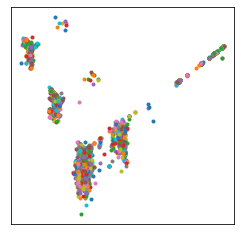

In [91]:
# 使用基于密度聚类的DBSCAN
model = DBSCAN(eps=0.1).fit(data)
draw(model, data)

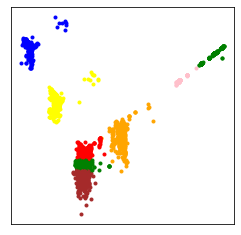

In [61]:
n_clusters = 8
model = KMeans(n_clusters=n_clusters).fit(data)
draw(model, data)

In [88]:
set_=set(model.labels_)
print(set_)
print(len(set_))

description0 = []
text_description0 = ""
k=0
for i in model.labels_:
    if i == 3:
        description0.append(list_repo_description[k])
        text_description0 += list_repo_description[k]
        text_description0 += " "
    k+=1

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, -1}
15


In [89]:
text = text_description0
#stopwords = set(['he', 'is'])
wc = WordCloud(
    #width=200,                  # 设置宽为400px
    #height=150,                 # 设置高为300px
    background_color='white',    # 设置背景颜色为白色
    #stopwords=stopwords,         # 设置禁用词，在生成的词云中不会出现set集合中的词
    #max_font_size=100,           # 设置最大的字体大小，所有词都不会超过100px
    #min_font_size=10,            # 设置最小的字体大小，所有词都不会超过10px
    #max_words=431,                # 设置最大的单词个数
    scale=2                     # 扩大两倍
)
wc.generate(text)
wc.to_file('img2.jpg')

In [37]:
# 统计比例
cluster_ = []
for i in range(len(set_)):
    cluster_.append([])
k=0
for i in model.labels_:
    cluster_[i].append(list_repo_org[k])
    k+=1

In [38]:
def draw_pie(n):
    dict_={}
    for item in cluster_[n]:
        if item in dict_.keys():
            dict_[item]=dict_[item]+1
        else:
            dict_[item]=1
    dict_=sorted(dict_.items(),key=lambda x:x[1],reverse=True)
    org = []
    frequency = []
    for i in range(len(dict_)):
        org.append(dict_[i][0])
        frequency.append(dict_[i][1])
    plt.pie(frequency, labels=org)
    plt.title('cluster_' + str(n))
    plt.show()
    return org

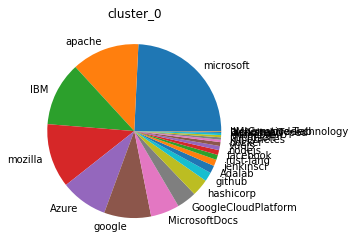

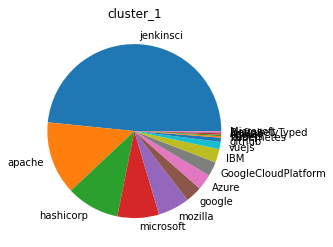

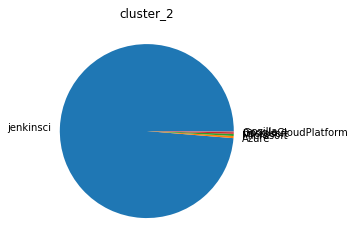

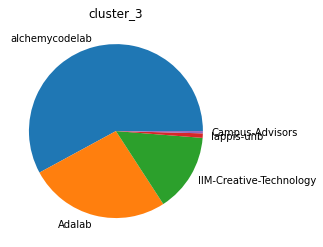

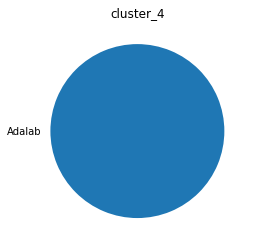

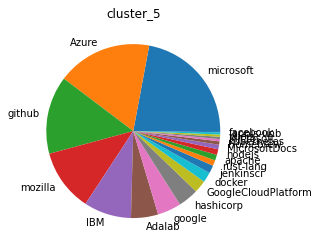

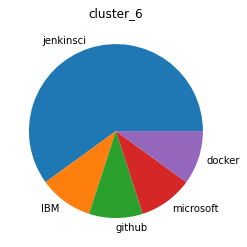

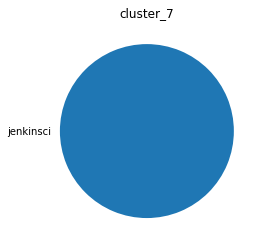

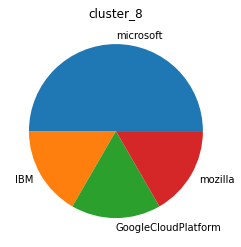

In [59]:
df_arr = []
for n in range(len(set_)):
    org = draw_pie(n)
    df_arr.append(org)

关联分析

支持度（support）：support(A=>B) = P(A∪B)，表示A和B同时出现的概率。

置信度（confidence）：confidence(A=>B)=support(A∪B) / support(A)，表示A和B同时出现的概率占A出现概率的比值。

In [48]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import pandas as pd

te = TransactionEncoder()
df_tf = te.fit_transform(df_arr)
df = pd.DataFrame(df_tf,columns=te.columns_)

#利用 Apriori,设置支持度求频繁项集
frequent_itemsets = apriori(df,min_support=0.5,use_colnames= True)
#print(frequent_itemsets)

#求关联规则,设置最小置信度为0.15
rules = association_rules(frequent_itemsets,metric = 'confidence',min_threshold = 0.8)

#设置最小提升度
#rules = rules.drop(rules[rules.lift <1.0].index)

In [75]:
rules.loc[:,['antecedents', 'consequents','confidence']]

,antecedents,consequents,confidence
0,(microsoft),(GoogleCloudPlatform),0.833333
1,(GoogleCloudPlatform),(microsoft),1.000000
2,(mozilla),(GoogleCloudPlatform),1.000000
3,(GoogleCloudPlatform),(mozilla),1.000000
4,(microsoft),(IBM),0.833333
5,(IBM),(microsoft),1.000000
6,(jenkinsci),(microsoft),0.833333
7,(microsoft),(jenkinsci),0.833333
8,(microsoft),(mozilla),0.833333
9,(mozilla),(microsoft),1.000000
